In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve

In [3]:
edited_df = pd.read_csv('eddited_bank.csv', sep=';')
edited_df.head()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,poutcome,y
0,58,management,married,tertiary,2143,yes,no,unknown,5,may,261,1,unknown,no
1,44,technician,single,secondary,29,yes,no,unknown,5,may,151,1,unknown,no
2,33,entrepreneur,married,secondary,2,yes,yes,unknown,5,may,76,1,unknown,no
3,47,blue-collar,married,unknown,1506,yes,no,unknown,5,may,92,1,unknown,no
4,33,unknown,single,unknown,1,no,no,unknown,5,may,198,1,unknown,no


### Functions for models

In [55]:
def evaluate(estimator, X_tr, X_h_te, y_tr, y_h_te):
    '''
    This is to evalute the best models and outputs are the metrics and matrix
    estimator: model,
    X_tr: X_train,
    X_h_te: X_hold_test,
    y_tr: y_training set,
    y_h_te: y_hold_test
    '''
#    predicts the models
    tr_preds = estimator.predict(X_tr)
    te_h_preds = estimator.predict(X_h_te)
    
    print("Training Scores:")
    print(f"Train Accuracy: {accuracy_score(y_tr, tr_preds)}")
#     print(precision_score(y_tr, tr_preds))
    print("*" * 10)
    print("Hold Out Scores:")
    print(f"Test Accuracy: {accuracy_score(y_h_te, te_h_preds)}")
    
#     creates a report of all the scores in test set
    print(classification_report(y_h_te, te_h_preds))
    
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(estimator, X_h_te, y_h_te)

### Data Preprocessing 

In [5]:
X = edited_df.drop('y', axis=1)
y = edited_df['y']

In [6]:
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
cat_col = [col for col in X.columns if X[col].dtype == 'object']
num_col = [col for col in X.columns if X[col].dtype != 'object']

In [8]:
# for transforming the numerical and categorical variables

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

In [9]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_col),
    ('cat', cat_transformer, cat_col)
])

### Model Building

In [10]:
classfier = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logisticregression', LogisticRegression(random_state=42))
])

# cross validating the training data 
output = cross_validate(classfier, X_train, y_train, cv=6, scoring='accuracy')
print(output['test_score'])

# outputs the test score of the cross validated sets

/Users/mac/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mac/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

0.9019145671202168


### Choosing hyperparameters for the models

In [11]:
# splitting the trainning data again to find the best possible model without using the test data
X_trained, X_test, y_trained, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [12]:
clf_two = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logistics regression', LogisticRegression(random_state=42, class_weight='balanced'))
])
# Now - cross_validate!
output_two = cross_validate(clf_two, X_trained, y_trained, cv=3, scoring=['accuracy', 'roc_auc'])
print(output_two['test_accuracy'])
print(output_two['test_roc_auc'])

[0.84285243 0.84351271 0.84164191]
[0.9083448  0.90905024 0.90676593]


In [13]:
clf_two.fit(X_trained, y_trained)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact', 'month',
                                                   'poutcome'])])),
                ('logistics regression',
                 Lo

In [14]:
clf_two.score(X_test, y_test)

0.8506851355376824

### Evaluate the cross validated sets

In [54]:
y_trained

25538    no
37632    no
38513    no
35663    no
22867    no
         ..
33343    no
36296    no
10805    no
8241     no
19565    no
Name: y, Length: 27261, dtype: object

Training Scores:
Train Accuracy: 0.8436227577858479
**********
Hold Out Scores:
Test Accuracy: 0.8506851355376824
              precision    recall  f1-score   support

          no       0.97      0.86      0.91     11802
         yes       0.44      0.82      0.57      1626

    accuracy                           0.85     13428
   macro avg       0.70      0.84      0.74     13428
weighted avg       0.91      0.85      0.87     13428



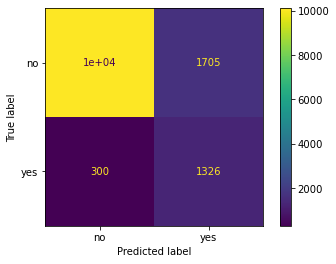

In [56]:
evaluate(clf_two, X_trained, X_test, y_trained, y_test)

### This model did not perform well as expected compared to the first model, tunning the parameters to give the best one

##### Tunning the model

In [16]:
clf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lgr', LogisticRegression(random_state=42, class_weight='balanced'))])
                    
    
params = {
    'lgr__C': [100, 10, 1.0, 0.1, 0.01],
    'lgr__max_iter': [100, 1000],
    'lgr__solver': ['sag', 'lbfgs']
}

cv = GridSearchCV(clf_pipe, param_grid=params)

cv.fit(X_trained, y_trained)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'balance',
                                                                          'day',
                                                                          'duration',
                                                                          'campaign']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                       

In [43]:
# cv.cv_results_

In [18]:
cv.best_params_

{'lgr__C': 1.0, 'lgr__max_iter': 100, 'lgr__solver': 'sag'}

### Evaluating the best model

Training Scores:
Train Accuracy: 0.8436594402259638
**********
Hold Out Scores:
Test Accuracy: 0.8506851355376824
              precision    recall  f1-score   support

          no       0.97      0.86      0.91     11802
         yes       0.44      0.82      0.57      1626

    accuracy                           0.85     13428
   macro avg       0.70      0.84      0.74     13428
weighted avg       0.91      0.85      0.87     13428



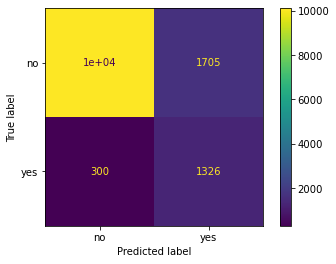

In [49]:
evaluate(cv.best_estimator_, X_trained, X_test, y_trained, y_test)

### Tunning the next combo of models

In [25]:
clf_again = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lgr', LogisticRegression(random_state=42))])

params = {
    'lgr__C': [100, 10, 1.0, 0.1, 0.01],
    'lgr__max_iter': [100, 1000],
    'lgr__solver': ['sag', 'lbfgs'],
    'lgr__class_weight': ['balanced', 'imbalanced']
}

cv_1 = GridSearchCV(clf_again, param_grid=params)

cv_1.fit(X_trained, y_trained)

/Users/mac/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/mac/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/mac/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/mac/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data a

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'balance',
                                                                          'day',
                                                                          'duration',
                                                                          'campaign']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                       

In [26]:
# the best model in this combination of models 
cv_1.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact', 'month',
                                                   'poutcome'])])),
                ('lgr',
                 LogisticRegression(

In [28]:
cv_1.best_params_

{'lgr__C': 100,
 'lgr__class_weight': 'imbalanced',
 'lgr__max_iter': 100,
 'lgr__solver': 'sag'}

#### Evaluating the best model

Training Scores:
Train Accuracy: 0.9036719122556033
**********
Hold Out Scores:
Test Accuracy: 0.8993893357164134
              precision    recall  f1-score   support

          no       0.91      0.98      0.94     11802
         yes       0.67      0.34      0.45      1626

    accuracy                           0.90     13428
   macro avg       0.79      0.66      0.70     13428
weighted avg       0.88      0.90      0.88     13428



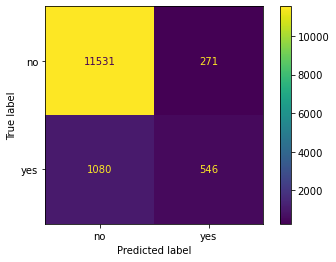

In [50]:
evaluate(cv_1.best_estimator_, X_trained, X_test, y_trained, y_test)

### comparing the model with the hold out sets

In [ ]:
# To evaluate the best model with the hold out sets 
evaluate(, X_train, X_hold, y_train, y_test)
